# Predict Patient No Shows

**Purpose**


**Learning Objectives**

**General Plan**
1. Setup our environment
2. Data Cleansing
3. Exploratory Data Analysis
4. Feature Engineering
5. Modeling Building
6. Model Refining
7. Who & what did we miss?

**Credit**<br>
Laura Brink, Deepak Kattilveettil, Joni Hoppen

## Setup our environment

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import ensemble
from sklearn import datasets
#may not need datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [170]:
#import csv data
df = pd.read_csv("KaggleV2-May-2016.csv")

This [public dataset](https://www.kaggle.com/joniarroba/noshowappointments) is hosted on Kaggle under [Creative Commons BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)


>[Kaggle](https://www.kaggle.com) is an online community of data scientists and machine learners, owned by Google LLC. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

[Kaggle Wikipedia Entry](https://en.wikipedia.org/wiki/Kaggle)

## Data Cleansing

In [4]:
#check if it worked
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
index = df.index

In [6]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

No-show is a bit confusing. Let's eliminate the negation. Also, let's cleanup the spelling on the column headers. 

In [7]:
#The only field with Yes/No is the No-Show column. Let's change this from 'no show' to 'attendance'. Thus patients 
#marked with Yes for no-show would be a 0 for attendance. 
df = df.replace('No', 1)
df = df.replace('Yes',0)

#Change Male to 1 and female to 0
df = df.replace('M',1)
df = df.replace('F', 0)

In [8]:
df = df.rename(columns={"PatientId": "PatientId", "AppointmentID": "AppointmentID", "Gender":"Gender", 
                   "ScheduledDay":"ScheduledDay","AppointmentDay":"AppointmentDay", "Age":"Age",
                   "Neighbourhood":"Neighborhood", "Scholarship":"Scholarship", "Hipertension":"Hypertension", 
                   "Diabetes":"Diabetes","Alcoholism":"Alcoholism","Handcap":"Handicap", "SMS_received":"SMS_Reminders",
                  "No-show":"Attendance"})

In [9]:
df.shape

(110527, 14)

There are 110527 total records in this dataset and 14 features

In [10]:
print(df.describe())



          PatientId  AppointmentID         Gender            Age  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06       0.350023      37.088874   
std    2.560949e+14   7.129575e+04       0.476979      23.110205   
min    3.921784e+04   5.030230e+06       0.000000      -1.000000   
25%    4.172614e+12   5.640286e+06       0.000000      18.000000   
50%    3.173184e+13   5.680573e+06       0.000000      37.000000   
75%    9.439172e+13   5.725524e+06       1.000000      55.000000   
max    9.999816e+14   5.790484e+06       1.000000     115.000000   

         Scholarship   Hypertension       Diabetes     Alcoholism  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.098266       0.197246       0.071865       0.030400   
std         0.297675       0.397921       0.258265       0.171686   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

Consider the age range of the dataset. We have patients aged -1 and 115. Let's remove outliers.

On first glance, we see that about 80% of patients attend their appointment. Is there anything about the 20% who do not make their appointment that would allow us to predict a no-show?

In [11]:
df.AppointmentDay.head()

0    2016-04-29T00:00:00Z
1    2016-04-29T00:00:00Z
2    2016-04-29T00:00:00Z
3    2016-04-29T00:00:00Z
4    2016-04-29T00:00:00Z
Name: AppointmentDay, dtype: object

In [12]:
df.ScheduledDay.head()

0    2016-04-29T18:38:08Z
1    2016-04-29T16:08:27Z
2    2016-04-29T16:19:04Z
3    2016-04-29T17:29:31Z
4    2016-04-29T16:07:23Z
Name: ScheduledDay, dtype: object

# Date Analysis

Let's take a look at what dates we're examining here. We have both scheduled date and appointment date to dig into. Unfortunately the appointment date only provides the day/month/year of the visit while scheduled date gives the time of day. Some features we can extract from this data:

- WaitingDays : difference between scheduled date and appointment date
- AppointmentDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- ScheduledDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- AppointmentTimeOfDay: AM / PM



In [13]:
#turn these columns into a pandas series
df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)

In [14]:
print("Appointments occur between",df.AppointmentDay.min(),"and", df.AppointmentDay.max())

Appointments occur between 2016-04-29 00:00:00+00:00 and 2016-06-08 00:00:00+00:00


This is roughly five weeks of appointments. This is likely another major limitation of building a model from this data.

In [15]:
##Create a new column that tracks the appointment day of week
df['AppointmentDayOfWeek'] = df.AppointmentDay.map(lambda day: day.day_name())
df.AppointmentDayOfWeek.head(10)

0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
5    Friday
6    Friday
7    Friday
8    Friday
9    Friday
Name: AppointmentDayOfWeek, dtype: object

In [16]:
SMSbyAppointment = df['SMS_Reminders'].groupby(df['AppointmentDayOfWeek'])

SMSbyAppointment.mean().plot.bar(color='green', alpha=0.5)

In [17]:
#creates dummy variables to account for these categories in our model
dummy = pd.get_dummies(df.AppointmentDayOfWeek)
df= pd.concat([df,dummy], axis =1)

In [18]:
##Create a new column that tracks the scheduled day of week
df['ScheduledDayOfWeek'] = df.ScheduledDay.map(lambda day: day.day_name())
df.ScheduledDayOfWeek.head(10)

0       Friday
1       Friday
2       Friday
3       Friday
4       Friday
5    Wednesday
6    Wednesday
7    Wednesday
8       Friday
9    Wednesday
Name: ScheduledDayOfWeek, dtype: object

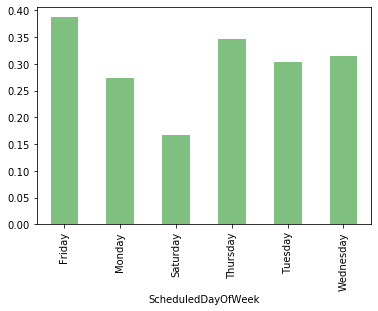

In [19]:
SMSbySchedule = df['SMS_Reminders'].groupby(df['ScheduledDayOfWeek'])

SMSbySchedule.mean().plot.bar(color='green',alpha=0.5)

The facilities are sending out fewer texts when the appointment was scheduled on a Saturday. How many instances are there of a patient scheduleding their appointment on a saturday?

In [20]:
df.ScheduledDayOfWeek.apply(lambda x: str(x))
df[df.ScheduledDayOfWeek=='Saturday'].shape

(24, 22)

24 instances of signups on saturday. Let's drop these outliers.

In [21]:
df = df[df.ScheduledDayOfWeek!='Saturday']

In [22]:
##This will calculate the days in between appointment and scheduling date. Since the appointment column doens't have a
## time of appointment, we're rounding here. Basically removing the time format from the ScheduledDate section.
WaitFromScheduledDate = (df.AppointmentDay.map(lambda x: x.date()) - df.ScheduledDay.map(lambda x: x.date()))

df['WaitFromScheduledDate'] = WaitFromScheduledDate.map(lambda x: x.days)
df.WaitFromScheduledDate.head(20)


0     0
1     0
2     0
3     0
4     0
5     2
6     2
7     2
8     0
9     2
10    2
11    3
12    1
13    1
14    1
15    3
16    1
17    1
18    3
19    0
Name: WaitFromScheduledDate, dtype: int64

So most patients schedule there appointment within a matter a days to their actual appointment. It seems outliers may exist around and past 50. Let's take a closer look.

Text(0, 0.5, 'Instances')

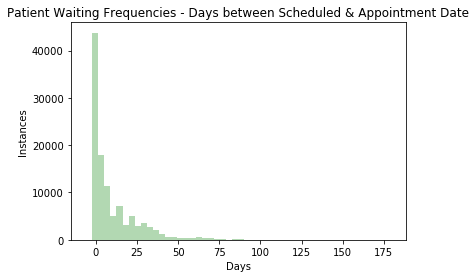

In [23]:

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df.WaitFromScheduledDate, bins = 50, color ='green', alpha = 0.3)
ax1.set_title('Patient Waiting Frequencies - Days between Scheduled & Appointment Date')
ax1.set_xlabel('Days')
ax1.set_ylabel('Instances')

In [24]:
print("There are", df[(df.WaitFromScheduledDate>75)].shape[0], "instances of patients setting appointments more than 75 days out.")
print("This accounts for", (df[(df.WaitFromScheduledDate>75)].shape[0]/df.shape[0])*100, "percent of the data")

There are 631 instances of patients setting appointments more than 75 days out.
This accounts for 0.5710252210347231 percent of the data


So most patients schedule there appointment within a matter a days to their actual appointment. It seems outliers may exist around and past 75. Let's see how many records account for WaitTime > 75 days

In [25]:
df = df[df.WaitFromScheduledDate <= 75]

In [26]:
df[df.WaitFromScheduledDate < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,...,Attendance,AppointmentDayOfWeek,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,ScheduledDayOfWeek,WaitFromScheduledDate
27033,7.839273e+12,5679978,1,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,0,0,0,...,0,Monday,0,1,0,0,0,0,Tuesday,-1
55226,7.896294e+12,5715660,0,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,0,0,0,...,0,Tuesday,0,0,0,0,1,0,Wednesday,-1
64175,2.425226e+13,5664962,0,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,0,0,0,...,0,Wednesday,0,0,0,0,0,1,Thursday,-1
71533,9.982316e+14,5686628,0,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,0,0,0,...,0,Thursday,0,0,0,1,0,0,Wednesday,-6
72362,3.787482e+12,5655637,1,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,0,0,0,...,0,Tuesday,0,0,0,0,1,0,Wednesday,-1


Negative difference between scheduled date and appointment day makes no sense. Drop these values.

In [27]:
df = df[df.WaitFromScheduledDate >= 0]
#Eliminate all records where wait time is less than 0 days

In [28]:
print("Now there are", df.shape[0], "records in the dataframe")

Now there are 109867 records in the dataframe


I want to get a better idea of how SMS reminders were utilized, especially with respect to the scheduled and appointment dates. Some patients received reminders, others did not. Why is that?

were texts sent on aparticular day? Was this an automated system? 

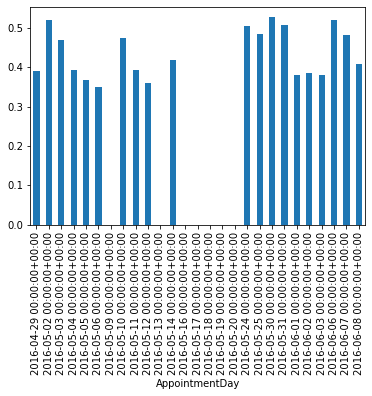

In [29]:
grouping = df['SMS_Reminders'].groupby(df['AppointmentDay'])
grouping.mean().plot.bar()



There's over a week of time where appointments were taken, but no SMS reminders were sent. was the system down? How many records is this?

In [30]:
df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].SMS_Reminders.mean()

0.0

In [31]:
print("There are", df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0], "records during this window",
     "or", (df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0]/df.shape[0])*100, "percent of the data")

There are 21252 records during this window or 19.343387914478416 percent of the data


Let's discard these data from our model. For whatever reason texts were not distributed for a whole week on an already limited dataset. So it's going to be very tricky to make any determinations about how texting affects the attendance rate without accounting for this week.

In [32]:
df = df[(df.AppointmentDay<"2016-05-15") | (df.AppointmentDay > "2016-05-23")]

In [33]:
grouping = df['Attendance'].groupby(df['WaitFromScheduledDate'])
grouping.mean().head(10)

WaitFromScheduledDate
0    0.953074
1    0.790497
2    0.756272
3    0.763569
4    0.771698
5    0.742049
6    0.758652
7    0.729199
8    0.716075
9    0.728827
Name: Attendance, dtype: float64

People who made appointments THAT day were very likely to show up. Maybe these were patients who didn't receive an SMS? Let's check that grouping.

In [34]:
grouping = df['SMS_Reminders'].groupby(df['WaitFromScheduledDate'])
grouping.mean().head(10)

WaitFromScheduledDate
0    0.000000
1    0.000000
2    0.000000
3    0.416283
4    0.720283
5    0.806439
6    0.800716
7    0.736434
8    0.751566
9    0.774670
Name: SMS_Reminders, dtype: float64

So patients who waited less than three days, did not receive SMS reminders for their appointment. 

In [35]:
print("Roughly", (df[df.WaitFromScheduledDate == 0].shape[0]/df.shape[0])*100, "percent of the records are of patients who scheduled their appointment on that very day") 

Roughly 35.30214974891384 percent of the records are of patients who scheduled their appointment on that very day


Of those patients, 95% attended their appointment - so this is significantly skewing our data. It's a pretty fair assumption then that people who schedule their appointment for later that day will likely arrive for that apppointment.

Let's remove the data among patients who scheduled an appointment that day. We already know that these folks attend their appointments. Since there's so many of them (~35% of the data) and they're not recieving texts - this is really skewing the relationship between texts and attendance. 

In [36]:
df= df[df.WaitFromScheduledDate != 0]

In [37]:
df.corr()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Reminders,Attendance,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,WaitFromScheduledDate
PatientId,1.000000,0.000473,0.007669,-0.005290,-0.003356,-0.004262,0.000902,0.004002,-0.003328,-0.004792,-0.003952,-0.001076,0.003295,-0.005962,-0.001970,-0.000243,0.000063,0.003019
AppointmentID,0.000473,1.000000,-0.003667,0.045439,0.012762,0.061124,0.042827,0.022294,0.016618,-0.104600,0.067339,-0.131158,-0.017351,0.005820,-0.035876,0.056721,0.104601,-0.712044
Gender,0.007669,-0.003667,1.000000,-0.098255,-0.111918,-0.036374,-0.014243,0.093602,0.022603,-0.038306,-0.000855,-0.001439,0.004745,-0.003686,0.009394,-0.008765,-0.002024,0.000872
Age,-0.005290,0.045439,-0.098255,1.000000,-0.103360,0.500378,0.285989,0.079386,0.077225,-0.062492,0.098600,-0.004298,-0.005902,0.015884,-0.003511,0.008141,0.003260,-0.042521
Scholarship,-0.003356,0.012762,-0.111918,-0.103360,1.000000,-0.027348,-0.027376,0.030372,-0.007729,0.024694,-0.045611,0.004483,-0.001814,-0.004891,-0.006484,0.007071,-0.003635,-0.023432
Hypertension,-0.004262,0.061124,-0.036374,0.500378,-0.027348,1.000000,0.429987,0.081872,0.085606,-0.053593,0.057618,0.001625,-0.000799,0.015698,0.001893,-0.000702,-0.002398,-0.080060
Diabetes,0.000902,0.042827,-0.014243,0.285989,-0.027376,0.429987,1.000000,0.020324,0.067283,-0.043681,0.022245,0.013162,-0.004211,0.010455,-0.003148,-0.001330,-0.004314,-0.058001
Alcoholism,0.004002,0.022294,0.093602,0.079386,0.030372,0.081872,0.020324,1.000000,0.017321,-0.010207,-0.016853,-0.004127,-0.004617,0.005815,0.003669,0.002494,0.002127,-0.027386
Handicap,-0.003328,0.016618,0.022603,0.077225,-0.007729,0.085606,0.067283,0.017321,1.000000,-0.029398,0.007405,-0.002510,0.003485,0.001852,0.006819,0.000373,-0.007112,-0.024903
SMS_Reminders,-0.004792,-0.104600,-0.038306,-0.062492,0.024694,-0.053593,-0.043681,-0.010207,-0.029398,1.000000,0.012224,-0.180801,0.002107,-0.009230,-0.034521,0.173146,0.014913,0.263785


In [38]:
def calculateHour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])
    return round(hour + minute/60 + second/3600)




In [39]:
df['ScheduledHourOfDay'] = df.ScheduledDay.apply(calculateHour)

We're not applying this to AppointmentDay because that level of specificity wasn't tracked across the appointments (only year - month - day)

In [40]:
df.corr()

,PatientId,AppointmentID,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Reminders,Attendance,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,WaitFromScheduledDate,ScheduledHourOfDay
PatientId,1.000000,0.000473,0.007669,-0.005290,-0.003356,-0.004262,0.000902,0.004002,-0.003328,-0.004792,-0.003952,-0.001076,0.003295,-0.005962,-0.001970,-0.000243,0.000063,0.003019,0.003000
AppointmentID,0.000473,1.000000,-0.003667,0.045439,0.012762,0.061124,0.042827,0.022294,0.016618,-0.104600,0.067339,-0.131158,-0.017351,0.005820,-0.035876,0.056721,0.104601,-0.712044,-0.007307
Gender,0.007669,-0.003667,1.000000,-0.098255,-0.111918,-0.036374,-0.014243,0.093602,0.022603,-0.038306,-0.000855,-0.001439,0.004745,-0.003686,0.009394,-0.008765,-0.002024,0.000872,0.007472
Age,-0.005290,0.045439,-0.098255,1.000000,-0.103360,0.500378,0.285989,0.079386,0.077225,-0.062492,0.098600,-0.004298,-0.005902,0.015884,-0.003511,0.008141,0.003260,-0.042521,-0.024540
Scholarship,-0.003356,0.012762,-0.111918,-0.103360,1.000000,-0.027348,-0.027376,0.030372,-0.007729,0.024694,-0.045611,0.004483,-0.001814,-0.004891,-0.006484,0.007071,-0.003635,-0.023432,-0.010961
Hypertension,-0.004262,0.061124,-0.036374,0.500378,-0.027348,1.000000,0.429987,0.081872,0.085606,-0.053593,0.057618,0.001625,-0.000799,0.015698,0.001893,-0.000702,-0.002398,-0.080060,-0.038208
Diabetes,0.000902,0.042827,-0.014243,0.285989,-0.027376,0.429987,1.000000,0.020324,0.067283,-0.043681,0.022245,0.013162,-0.004211,0.010455,-0.003148,-0.001330,-0.004314,-0.058001,-0.015361
Alcoholism,0.004002,0.022294,0.093602,0.079386,0.030372,0.081872,0.020324,1.000000,0.017321,-0.010207,-0.016853,-0.004127,-0.004617,0.005815,0.003669,0.002494,0.002127,-0.027386,-0.007406
Handicap,-0.003328,0.016618,0.022603,0.077225,-0.007729,0.085606,0.067283,0.017321,1.000000,-0.029398,0.007405,-0.002510,0.003485,0.001852,0.006819,0.000373,-0.007112,-0.024903,0.000520
SMS_Reminders,-0.004792,-0.104600,-0.038306,-0.062492,0.024694,-0.053593,-0.043681,-0.010207,-0.029398,1.000000,0.012224,-0.180801,0.002107,-0.009230,-0.034521,0.173146,0.014913,0.263785,-0.001111


This will return the hour of the day closest to when the apointment was scheduled. Perhaps there's a time of day when setting follow-up reminders in place are missed. 

Few insights from this new variable

- Patients are less likely to attend appointments later int the day
- Older patients schedule earlier appointments in the day
- Appointments scheduled further out are placed later in the day

In [41]:
print("There are",len(df.PatientId.unique()),"unique patients in the data")
print("There are",len(df.AppointmentID.unique()),"unique appointment Ids in the data")
##There are 62299 unique patient Ids here... 
##Whoa okay so only 56% of the records here are unique. So we could create a multiple column... Number of missed appointments
##Might that new column be a predictor


There are 38827 unique patients in the data
There are 57332 unique appointment Ids in the data


In [42]:
print((df.PatientId.unique().shape[0]/df.shape[0])*100, "percent of the data are unique patients")
print((100 - (df.PatientId.unique().shape[0]/df.shape[0])*100),"instances are returning patients")

67.72308658340891 percent of the data are unique patients
32.276913416591086 instances are returning patients


In [43]:
df.dtypes

PatientId                            float64
AppointmentID                          int64
Gender                                 int64
ScheduledDay             datetime64[ns, UTC]
AppointmentDay           datetime64[ns, UTC]
Age                                    int64
Neighborhood                          object
Scholarship                            int64
Hypertension                           int64
Diabetes                               int64
Alcoholism                             int64
Handicap                               int64
SMS_Reminders                          int64
Attendance                             int64
AppointmentDayOfWeek                  object
Friday                                 uint8
Monday                                 uint8
Saturday                               uint8
Thursday                               uint8
Tuesday                                uint8
Wednesday                              uint8
ScheduledDayOfWeek                    object
WaitFromSc

In [44]:
import matplotlib.pyplot as plt
ScheduledAppointmentFrequencies = pd.value_counts(df.PatientId.values, sort=True)


print("The mean number of scheduled appointments is ", ScheduledAppointmentFrequencies.mean())
ScheduledAppointmentFrequencies.describe()


The mean number of scheduled appointments is  1.4766013341231616


count    38827.000000
mean         1.476601
std          1.035574
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         25.000000
dtype: float64

Text(0, 0.5, 'Count of patients')

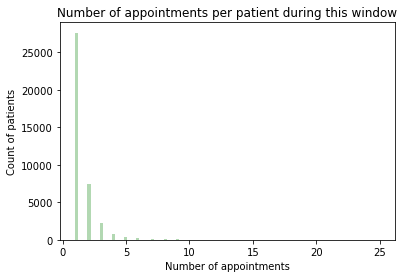

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(ScheduledAppointmentFrequencies, bins = 100, color ='green', alpha = 0.3)
ax1.set_title('Number of appointments per patient during this window')
ax1.set_xlabel('Number of appointments')
ax1.set_ylabel('Count of patients')

We can see from this data that not many patients have scheduled more than five appointments for this month long period. We should be able to say that patients scheduling ten or more times are outliers and should be treated differently by this model. These patients are basically seen once every two-three days- should be fair to assume that you'd develop more of a relationship with the patient and depend on the trust within that relationship.

In [46]:
print("There are",ScheduledAppointmentFrequencies[ScheduledAppointmentFrequencies>=15].shape[0],"patients with 15 or more visits this month")

There are 7 patients with 15 or more visits this month


In [47]:
SIndex=ScheduledAppointmentFrequencies[ScheduledAppointmentFrequencies>=15].index


In [48]:
#This will find all the records among patients who have scheduled 10 or more appointments in the month and drop them from the dataframe.

df= df[-df.PatientId.isin(list(SIndex))]

In [49]:
df.Attendance.mean()

0.7196119559517566

So we've removed everyone who has more than 10 appointments in the one month period. Checking the attendance rate we're at about 72%. So our model is geared more towards the less frequent population who has not scheduled their appointment for that day and also not very far out on the scale of over three months out. 


Let's add another feature to this data that points out just how many appointments the patient scheduled during this window. 

In [50]:
frequency = pd.value_counts(df.PatientId.values, sort=True, normalize=True)
apptfreqdict={}

for entry in frequency.index:
    apptfreqdict[entry] = frequency[entry]

In [51]:
df['ApptFreq'] = pd.Series(df.PatientId, index=df.index)
df['ApptFreq']= df['ApptFreq'].map(apptfreqdict)
#Apptfreq is the number of appointments the patient has scheduled during this window. 



Just as we've added a feature indicating how frequently someone schedules appointments. We should add a feature that indicates how many appointments this patient has missed. The best indicator for future behavior is past behavior.

In [52]:

x= df[df.Attendance == 0]
FreqOfNoShow={}
for x in df.PatientId.unique():
    FreqOfNoShow[x]=0
    #df['word'].value_counts()


In [53]:
absencelist = df[df.Attendance == 0].loc[:,'PatientId']
AbsenceFreq = pd.value_counts(absencelist.values, sort=True, normalize = True)


In [54]:
AbsenceFreq
#AbsenceFreq will be a normalized value that represents how often a patient misses their appointment.
FreqOfNoShow={}
for entry in AbsenceFreq.index:
    FreqOfNoShow[entry] = AbsenceFreq[entry]



In [55]:
df['AbsenceFreq'] = pd.Series(df.PatientId, index=df.index)
df['AbsenceFreq']= df['AbsenceFreq'].map(FreqOfNoShow)
df['AbsenceFreq']= df['AbsenceFreq'].fillna(0)


In [56]:
import seaborn as sns

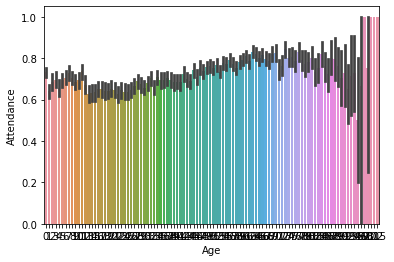

In [57]:
sns.barplot(x='Age',y='Attendance', data=df, orient = 'v')

Lots of variance in the much older population. Any way to combat this?

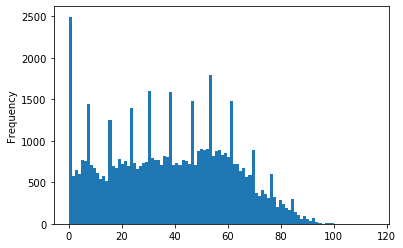

In [58]:
df['Age'].plot.hist(bins =100)

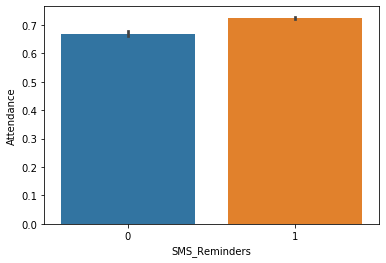

In [59]:
sns.barplot(x='SMS_Reminders',y='Attendance', data=df[df.WaitFromScheduledDate >2], orient = 'v')
#Recall that no texts were sent if the appointment was less than three days away from the schedule date.
#To get a proper sense of this relationship we are only looking at instances where texts may have been sent.

In [60]:
JardimCamburi = df[df.Neighborhood == "JARDIM CAMBURI"]
MariaOrtiz = df[df.Neighborhood == "MARIA ORTIZ"]
JardimDaPenha = df[df.Neighborhood == "JARDIM DA PENHA"]

In [61]:
print("Jardim Camburi: Attendance =",JardimCamburi.Attendance.mean(), "Count = ",JardimCamburi.shape[0])
print("Maria Ortiz: Attendance = ",MariaOrtiz.Attendance.mean(), "Count =", MariaOrtiz.shape[0])
print("Jardim Da Penha: Attendance = ",JardimDaPenha.Attendance.mean(),"Count = ", JardimDaPenha.shape[0])


Jardim Camburi: Attendance = 0.7481724224855054 Count =  3967
Maria Ortiz: Attendance =  0.7032193158953722 Count = 2982
Jardim Da Penha: Attendance =  0.7759355755566082 Count =  2111


These are three neighborhoods that ranked of high importance in random forest models. Will keep the dataframes around to analyze. 

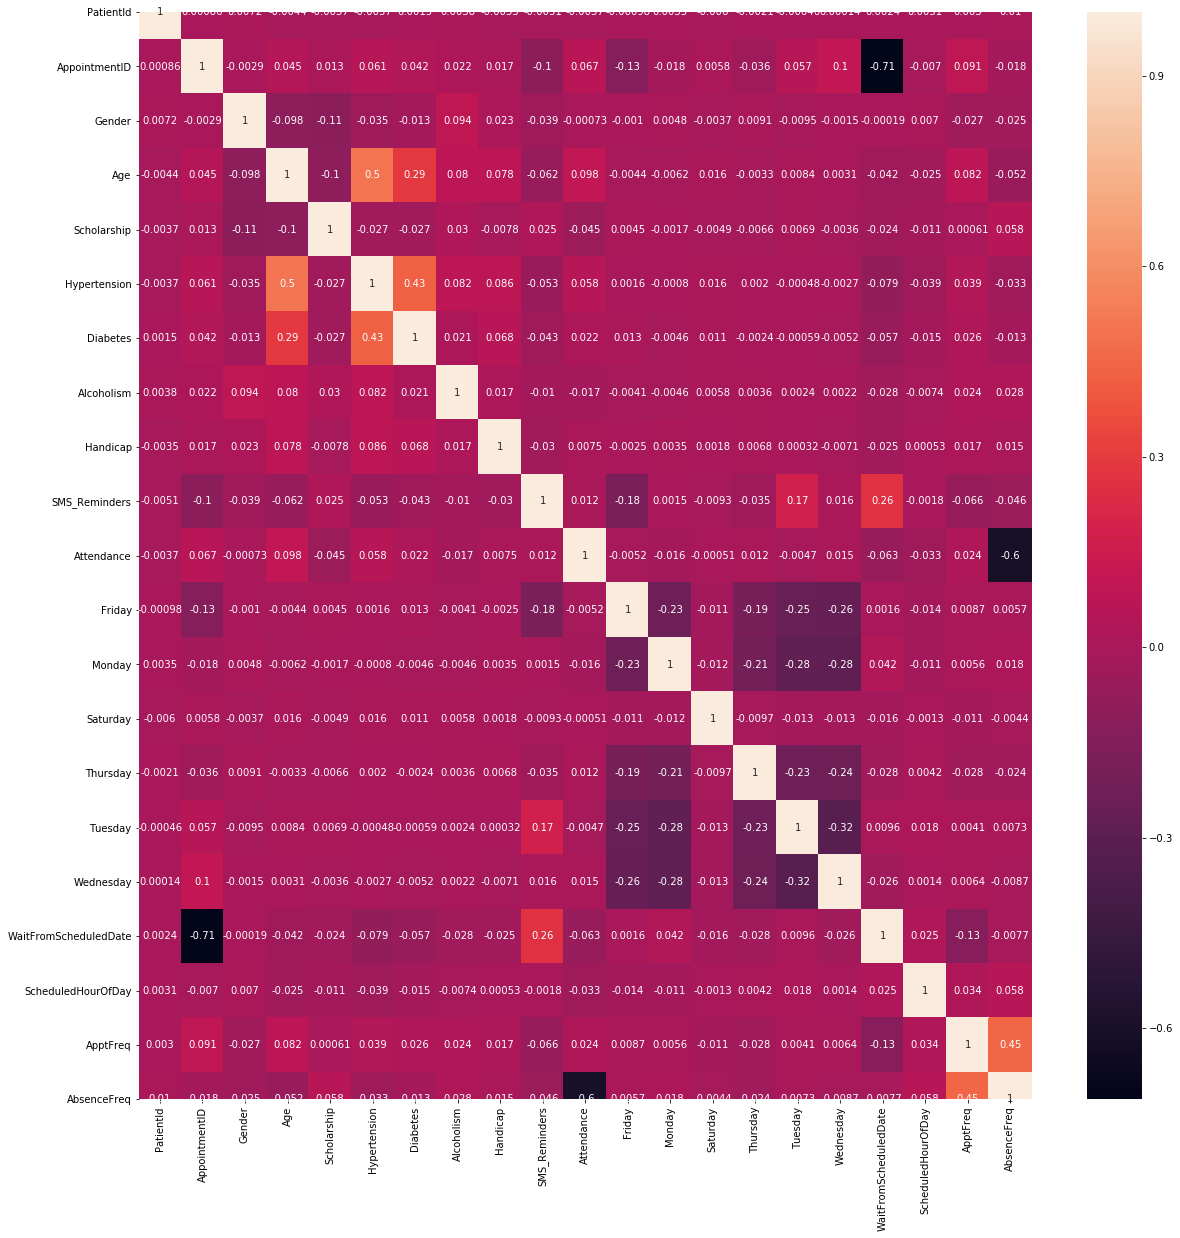

In [62]:
plt.figure(figsize = (20,20))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.show()

In [63]:
df.dtypes

PatientId                            float64
AppointmentID                          int64
Gender                                 int64
ScheduledDay             datetime64[ns, UTC]
AppointmentDay           datetime64[ns, UTC]
Age                                    int64
Neighborhood                          object
Scholarship                            int64
Hypertension                           int64
Diabetes                               int64
Alcoholism                             int64
Handicap                               int64
SMS_Reminders                          int64
Attendance                             int64
AppointmentDayOfWeek                  object
Friday                                 uint8
Monday                                 uint8
Saturday                               uint8
Thursday                               uint8
Tuesday                                uint8
Wednesday                              uint8
ScheduledDayOfWeek                    object
WaitFromSc

# Train & Test Split

In [64]:

# Putting feature variable to X
X = df.drop(['Attendance', 'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'AppointmentDayOfWeek','ScheduledDayOfWeek', 'Neighborhood',] ,axis=1)
# Putting response variable to y
y = df['Attendance']
X.dtypes

Gender                     int64
Age                        int64
Scholarship                int64
Hypertension               int64
Diabetes                   int64
Alcoholism                 int64
Handicap                   int64
SMS_Reminders              int64
Friday                     uint8
Monday                     uint8
Saturday                   uint8
Thursday                   uint8
Tuesday                    uint8
Wednesday                  uint8
WaitFromScheduledDate      int64
ScheduledHourOfDay         int64
ApptFreq                 float64
AbsenceFreq              float64
dtype: object

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)

because the data is heavy with patients who showed up to their appointment (roughly 80/20 breakdown) - we need to adjust our data to better represent these minority populations (the no shows) 

</br> 
</br>
We will use the Smote technique. See explanation here: https://medium.com/erinludertblog/smote-synthetic-minority-over-sampling-technique-caada3df2c0a

In [66]:

sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


(65888, 18)
(65888,)


In [67]:
X_tr.dtype
#Train = pd.concat([X_tr, y_tr], axis=1)
#Train.columns

dtype('float64')

In [68]:

logmodel = LogisticRegression()


In [69]:
logmodel.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_predict = logmodel.predict(X_test)

In [71]:

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.33      0.58      0.42      3217
           1       0.77      0.54      0.63      8225

    accuracy                           0.55     11442
   macro avg       0.55      0.56      0.53     11442
weighted avg       0.64      0.55      0.57     11442



In [72]:

tn, fp, fn, tp = confusion_matrix( y_test, y_predict).ravel()
print((tn, fp, fn, tp))
print(confusion_matrix( y_test, y_predict))

(1861, 1356, 3769, 4456)
[[1861 1356]
 [3769 4456]]


True negative, False Positive

False Negative, True Positive

This is a pretty cruddy model to represent the data. But it does give us a starting point. What sort of statistics would we generate from a model that predicted everyone would show up?

In [73]:

AllOnesPredict= np.ones((11442,))

In [74]:

print(confusion_matrix(y_test, AllOnesPredict))
print(classification_report(y_test, AllOnesPredict ))

[[   0 3217]
 [   0 8225]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3217
           1       0.72      1.00      0.84      8225

    accuracy                           0.72     11442
   macro avg       0.36      0.50      0.42     11442
weighted avg       0.52      0.72      0.60     11442



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We need to improve upon a 72% accuracy score with any model we propose. 

This might be too painstaking to pull a list of municipalities for ech state and match it with the dataset

Okay so I mapped all the neighborhoods on Google Maps to find trends in our data: 

https://drive.google.com/open?id=1jTljTssx4dSY84k-CljRAg3YB0LOUVLO&usp=sharing

I plotted each neighborhood on the map. But now  I want to consider where all the clincics/hospitals are in Vitoria. This should help me make bins for all the locations. What groups are likely going to the same facility?

The red denotes a hospital/ clinic / 


Okay so I need to figure out the specific lines to differeniate regions. Region 1 makes sense - no clinics/ hospitals in the the near vicinity. These people will need to travel the furthest. 

Region 2 has one local facility but is the next most rural population in the group. Neighborhoods are slightly more dense thatn region 1. 

Okay what's goiong on in jardim de penha. Are there are lot of visits from this neighborhood? Same with Pontal de Camburi. IF there are a lot of visits between those two, then we should create its own bucket. 

Okay, so two neighborhoods out of 80 possible. Let's make a quick (clearly incorrect) assumption that these neighborhoods are evently distributed and make clinical appointments at similar frequencies. So these neighborhoods should account for 2.5% of the total data. If these neighborhoods actually account for more, then we will create separate buckets to see what's going on. 



In [75]:
AttendCorr = df.corr()
AttendCorr = AttendCorr.Attendance
AttendCorr.abs().sort_values(ascending=False).head(n=20)


Attendance               1.000000
AbsenceFreq              0.601630
Age                      0.098164
AppointmentID            0.067378
WaitFromScheduledDate    0.063149
Hypertension             0.057608
Scholarship              0.045461
ScheduledHourOfDay       0.032734
ApptFreq                 0.024082
Diabetes                 0.021774
Alcoholism               0.016772
Monday                   0.016450
Wednesday                0.014752
SMS_Reminders            0.012448
Thursday                 0.011900
Handicap                 0.007487
Friday                   0.005163
Tuesday                  0.004741
PatientId                0.003653
Gender                   0.000727
Name: Attendance, dtype: float64

In [76]:
df.dtypes

PatientId                            float64
AppointmentID                          int64
Gender                                 int64
ScheduledDay             datetime64[ns, UTC]
AppointmentDay           datetime64[ns, UTC]
Age                                    int64
Neighborhood                          object
Scholarship                            int64
Hypertension                           int64
Diabetes                               int64
Alcoholism                             int64
Handicap                               int64
SMS_Reminders                          int64
Attendance                             int64
AppointmentDayOfWeek                  object
Friday                                 uint8
Monday                                 uint8
Saturday                               uint8
Thursday                               uint8
Tuesday                                uint8
Wednesday                              uint8
ScheduledDayOfWeek                    object
WaitFromSc

In [77]:

cols =['Gender', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday', 'WaitFromScheduledDate',
       'ScheduledHourOfDay', 'ApptFreq', 'AbsenceFreq']
X = df[cols]
y = df['Attendance']
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs', max_iter = 3000)
# create the RFE model and select 12 attributes
rfe = RFE(model,10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


Selected features: ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_Reminders', 'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday']


Received a warning about convergence. "Failed to converge. Increase the number of iteration. Will first try this, then normalize my variables. 

Optimal number of features: 13
Selected features: ['Gender', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_Reminders', 'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledHourOfDay']


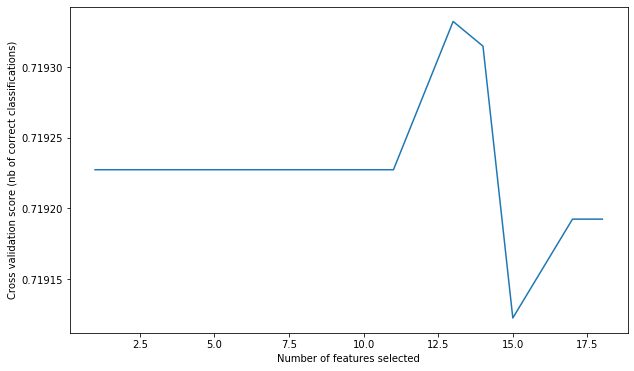

In [78]:

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=3000), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**These are the variables that seem to play a significant impact on modeling Attendance:**

['Gender', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'SMS_Reminders', 'Friday', 'Monday', 'Thursday', 'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledHourOfDay']

This bit is out of place. Find a new home

Potential relationships to investigate (pulled from the correlation table.<br />
AppointmentID : SMS<br />
Age : Gender<br />
Age : Scholarship<br />
Age : Jesus De Nazerth<br />
Age : Handicap<br />
Scholarship : Ilha do principe<br />
Scholarship : Sao Bendito<br />
Hypertension : Age<br />
Hypertension : Diabetes<br />
Diabetes : Age<br />
Alcoholism : Gender<br />
ApptFreq : Alcoholism<br />
Alcholism: Santa MArtha<br />
Scholarship : AbsenceFreq<br />
Gurigica : Scholarship<br />
Jardim Camburi : AGe<br />
Jarfim Da Penha : Age<br />
Hypertension : 1 Handicap

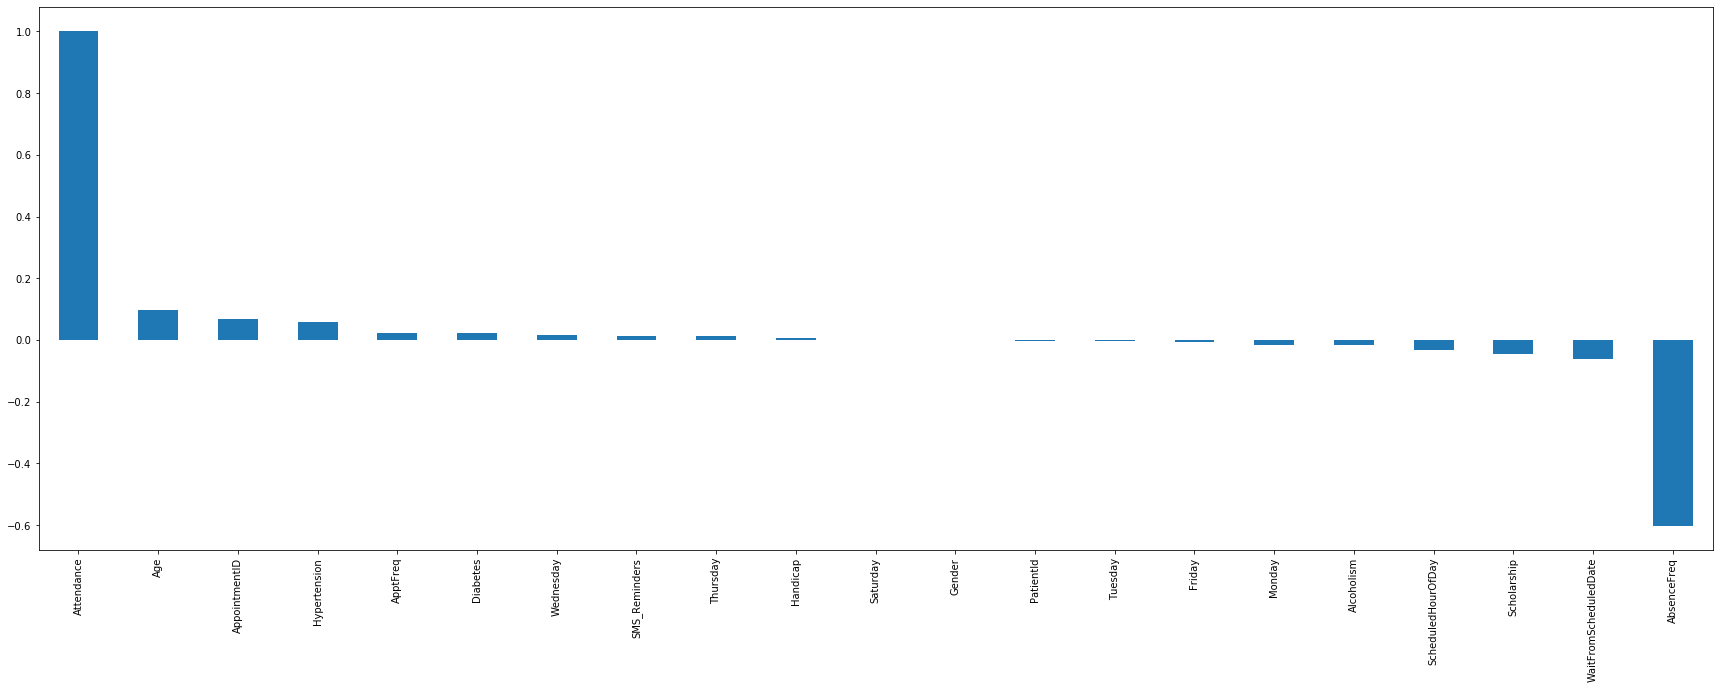

In [79]:
## Correlations between Attendance and other variables
plt.figure(figsize=(30,10))
df.corr()['Attendance'].sort_values(ascending = False).plot(kind='bar')
plt.show()

In [80]:
def plot_continuous_chart(axe, title, plottype, col, df, log):
    axe.set_title(title)
    if log==True:
        axe.set_yscale('log')
    if (plottype=='d'):   
        sns.distplot(df[col],ax=axe)
    else: 
        sns.boxplot(data =df, x=col,ax=axe,orient='v')
        
def plot_univariate(vtype,col,hue =None,log=False,vertlabel=False, flipvertical=False):
    if vtype == 'continuous':
        fig, ax=plt.subplots(nrows =1,ncols=4,figsize=(15,5))
        plot_continuous_chart(ax[0], "Box Plot", 'b', col, df, log)
        plot_continuous_chart(ax[1], "Distribution Plot", 'd', col, df, log)
        plot_continuous_chart(ax[2], "Box Plot for Show Up", 'b', col, df[df.Attendance == 1], log)
        plot_continuous_chart(ax[3], "Box Plot for No Show", 'b', col, df[df.Attendance == 0], log)
    else:
        fig, ax = plt.subplots()
        hue_col = pd.Series(data = hue)
        width = len(df[col].unique()) + 4 + 2*len(hue_col.unique())
        if flipvertical==True:
            fig.set_size_inches(6 , 8)
            ax = sns.countplot(data = df, y= col, order=df[col].value_counts().index,hue = hue) 
        else:
            fig.set_size_inches(width , 12)
            ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
            for p in  ax.patches:
                if (p.get_height() > 0):
                    ax.annotate('{:1.2f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
    if (vertlabel== True): 
        plt.xticks(rotation=90)
    plt.show() 

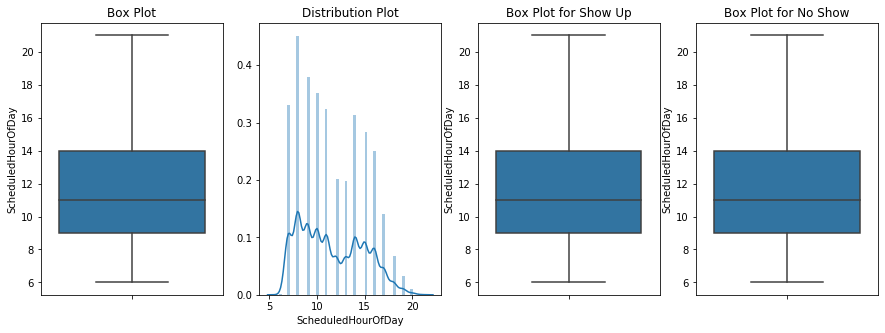

In [81]:
plot_univariate(vtype = 'continuous', col='ScheduledHourOfDay', log=False)

In [82]:


model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Random Forest Accuracy with Default Hyperparameter on the test set',metrics.accuracy_score(y_test, prediction_test))
print('Random Forest AUC with Default Hyperparameter on the test set',metrics.roc_auc_score(y_test, prediction_test))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy with Default Hyperparameter on the test set 0.894861038280021
Random Forest AUC with Default Hyperparameter on the test set 0.876902530534499


In [83]:


# GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [84]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.150643,0.026509,0.012449,0.002239,2,{'max_depth': 2},0.914057,0.911843,0.949140,0.804567,...,0.900399,0.049721,4,0.923893,0.928181,0.929566,0.734756,0.920375,0.887354,0.076368
1,0.264449,0.017424,0.014450,0.001259,7,{'max_depth': 7},0.970175,0.966044,0.993755,0.991429,...,0.982548,0.011893,3,0.989476,0.985588,0.981881,0.978564,0.977485,0.982599,0.004453
2,0.302852,0.035487,0.015153,0.000740,12,{'max_depth': 12},0.975715,0.977203,0.998256,0.997404,...,0.989207,0.010424,1,0.995300,0.995391,0.991483,0.991829,0.991336,0.993068,0.001867
3,0.377238,0.046266,0.017813,0.001164,17,{'max_depth': 17},0.974563,0.976492,0.998499,0.998161,...,0.989110,0.011109,2,0.998585,0.998451,0.997118,0.997258,0.997028,0.997688,0.000683


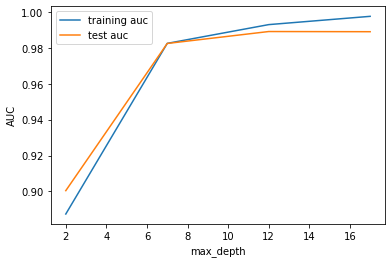

In [85]:


# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.legend()
plt.show()



In [86]:
#GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

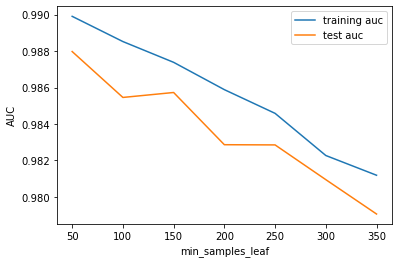

In [87]:
# plotting auc's with min_samples_leaf
scores = rf.cv_results_
pd.DataFrame(scores).head()
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [88]:
# GridSearchCV to find optimal n_estimators



# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(300, 800, 100)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

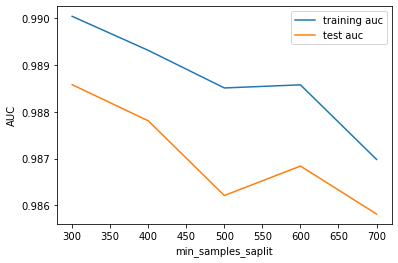

In [89]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_saplit")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [90]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(300, 700, 200),
    'n_estimators': [100,200], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring = 'roc_auc')

In [91]:
grid_search.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [92]:
# printing the optimal accuracy score and hyperparameters
print('We can get an auc of',grid_search.best_score_,'using',grid_search.best_params_)

We can get an auc of 0.9875427070168388 using {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 300, 'n_estimators': 200}


In [93]:
# Fitting the RandomForestClassifier using the best parameters obtained by Grid Search CV on the train set
m1= RandomForestClassifier(n_estimators=100,max_depth=8, min_samples_leaf=100,min_samples_split=300, max_features=10, n_jobs=-1)
m1.fit(X_tr,y_tr)
m1.score(X_test,y_test)

0.9052613179514071

In [94]:
#Predicting probabilities on the balanced training data set, imbalanced training data set and tst set
y_trprob = m1.predict_proba(X_tr)[:,1]
y_trainprob = m1.predict_proba(X_train)[:,1]
y_testprob = m1.predict_proba(X_test)[:,1]

In [95]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the balanced training dataset
y_tr_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), y_trprob.tolist())),
              columns=['Attendance','Attendance_prob'])


In [96]:


# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the imbalanced training dataset
y_train_pred_final = pd.DataFrame(list(zip(y_train.tolist(), y_trainprob.tolist())),
              columns=['Attendance','Attendance_prob'])



In [97]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the testing dataset
y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), y_testprob.tolist())),
              columns=['Attendance','Attendance_prob'])

In [98]:


# Defining a function to plot the ROC-AUC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None



In [99]:
fpr, tpr, thresholds = metrics.roc_curve( y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob, drop_intermediate = False )

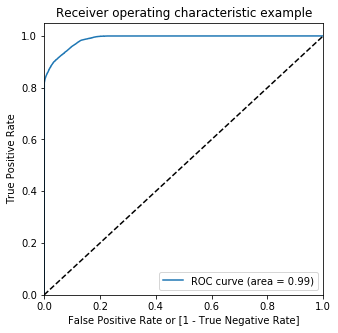

In [100]:
#Fitting on the balanced dataset
draw_roc(y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob)

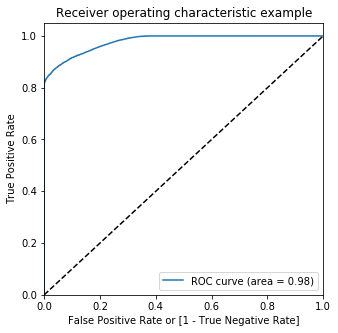

In [101]:
#Fitting on the imbalanced dataset
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Attendance, y_train_pred_final.Attendance_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Attendance, y_train_pred_final.Attendance_prob)

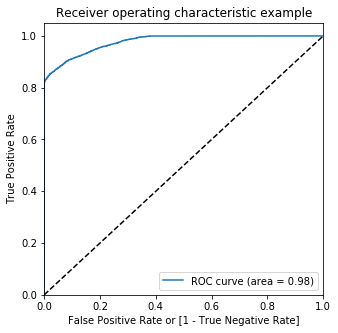

In [102]:
##Fitting on the test set
fpr, tpr, thresholds = metrics.roc_curve(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob, drop_intermediate = False )
draw_roc(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob)

In [103]:
# Let's create columns with different probability cutoffs on the test set
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.Attendance_prob.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

,Attendance,Attendance_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,1.000000,1,1,1,1,1,1,1,1,1,1
1,0,0.310405,1,1,1,1,0,0,0,0,0,0
2,0,0.293513,1,1,1,0,0,0,0,0,0,0
3,1,1.000000,1,1,1,1,1,1,1,1,1,1
4,0,0.029037,1,0,0,0,0,0,0,0,0,0


In [104]:


# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci'])


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]
print(cutoff_df)



     prob  accuracy     sensi     speci     preci
0.0   0.0  0.718843  1.000000  0.000000  0.718843
0.1   0.1  0.886209  1.000000  0.595275  0.863336
0.2   0.2  0.897658  0.996353  0.645322  0.877785
0.3   0.3  0.906747  0.971307  0.741685  0.905782
0.4   0.4  0.908757  0.916353  0.889338  0.954897
0.5   0.5  0.905261  0.897508  0.925085  0.968385
0.6   0.6  0.890229  0.858237  0.972024  0.987411
0.7   0.7  0.875721  0.828207  0.997202  0.998681
0.8   0.8  0.868904  0.817629  1.000000  1.000000
0.9   0.9  0.868904  0.817629  1.000000  1.000000


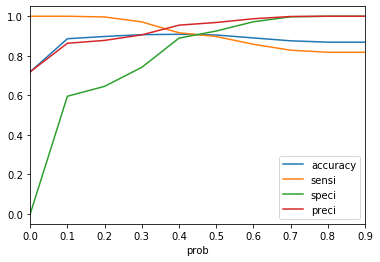

In [105]:


# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci', 'preci'])
plt.show()



In [106]:

metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.4])

array([[2861,  356],
       [ 688, 7537]])

In [107]:
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.4]))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      3217
           1       0.95      0.92      0.94      8225

    accuracy                           0.91     11442
   macro avg       0.88      0.90      0.89     11442
weighted avg       0.91      0.91      0.91     11442



Great overall scores! 91% accuracy. But what exactly does all this mean? 


So 80% precision rate for patients that don't attend their appointment. This mean that whenver the algorithm predicts no-show, 80% of the time it is correct. However 20% of the time, those are false negatives. 

Recall is a measures the algorithm against all the true labels. So of all the no-show patients, we were able to correctly predict 89% of them. The other 11% the algorithm predicted that they would show up.


Herein lies the grounds for tweaking the algorithm. It's better to err on the side of caution and assume more patients will come to their appointment than to assume they will miss. So we can tolerate reduction to the recall rate. Precision is what we'd really like to improve. When the algorithm predicts negative, we want to hold a high degree of confidence that the patient will not show up before taking alternative course of action.

In [108]:
metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.3])

array([[2386,  831],
       [ 236, 7989]])

In [109]:
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.3]))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      3217
           1       0.91      0.97      0.94      8225

    accuracy                           0.91     11442
   macro avg       0.91      0.86      0.88     11442
weighted avg       0.91      0.91      0.90     11442



WE have correctly identified 2415 patients who missed their appointment. Only 243 patients were predicted to miss but actually showed up. 

This however misses 802 patients who missed their appointment, which the algorithm classified as attending. This is the algorithmic cost of greater certainty that that the algorithm will correct an actual no-show. 

Is there anything interesting we can dig up on the population that gets cut here?

**What do we observe about the 243 patients who were predicted to miss but actually showed up?**

**What do we observe about the 802 patients who were predicted to attend, but missed their appointment?**

In [110]:


feature_importances = pd.DataFrame(m1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)



,importance
AbsenceFreq,0.873254
ApptFreq,0.094343
Hypertension,0.009918
Gender,0.008443
Age,0.005337
WaitFromScheduledDate,0.003529
SMS_Reminders,0.001834
ScheduledHourOfDay,0.001001
Wednesday,0.000535
Tuesday,0.000463


Okay so... As we expected, prior absences are the best predictor for future absences. Variables drop off in importance pretty rapidly afterward. 

What's more interesting are the nieghborhoods that are in the top ten on the list (Jardim Camburi & Maria Ortiz). What's happening in these areas that is potentially impacting the rate at which people attend their appointments?


**Analysis of Jardim Camburi**
Compare their attendance rates to the wider population.

In [111]:
JC=df[df.Neighborhood == 'JARDIM CAMBURI']
MO=df[df.Neighborhood == 'MARIA ORTIZ']
print(JC.shape, MO.shape)


(3967, 26) (2982, 26)


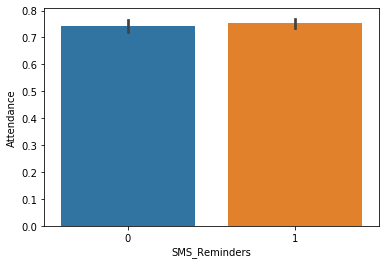

In [112]:
sns.barplot(x='SMS_Reminders',y='Attendance', data=JC, orient = 'v')


Okay so people in Jardim Camburi are attneding their appointments more than others in Vitoria. Is this significant?

People in Maria Ortiz are not attending their appointments as frequently.

In [113]:
grouping = df['SMS_Reminders'].groupby(df['WaitFromScheduledDate'])
WaitFromScheduledDate
grouping.mean().head(75)

WaitFromScheduledDate
1     0.000000
2     0.000000
3     0.416398
4     0.720180
5     0.805753
        ...   
71    0.816327
72    0.622222
73    0.424242
74    0.900000
75    0.761905
Name: SMS_Reminders, Length: 75, dtype: float64

No messages were sent for patients that scheduled their appointment less than three days away. Interesting. Even for three days out, there was only a third of patients who received an SMS. Let's see what affect that had on the attendance.

In [114]:
grouping2 = df['Attendance'].groupby(df['WaitFromScheduledDate'])

grouping2.mean().head(50)

WaitFromScheduledDate
1     0.790586
2     0.755184
3     0.764164
4     0.771401
5     0.741529
6     0.758600
7     0.728849
8     0.715481
9     0.728405
10    0.699722
11    0.695990
12    0.710615
13    0.690580
14    0.697267
15    0.676692
16    0.698413
17    0.688356
18    0.708029
19    0.665031
20    0.657077
21    0.691307
22    0.682628
23    0.674963
24    0.660455
25    0.596886
26    0.633028
27    0.692825
28    0.717345
29    0.680265
30    0.730402
31    0.698312
32    0.626728
33    0.670588
34    0.672956
35    0.637376
36    0.698690
37    0.658363
38    0.660256
39    0.670886
40    0.602620
41    0.660000
42    0.620596
43    0.702830
44    0.713115
45    0.613208
46    0.666667
47    0.679487
48    0.712766
49    0.668874
50    0.735484
Name: Attendance, dtype: float64

Well we see a pretty high attendance rate among patients who scheduled an appointment less than three days away. So maybe this practice doesn't think it's neccessary to text those folks. This could help explain the attendance rate x sms.


# PCA Analysis

"Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set. Richard Bellman described this phenomenon in 1961 as the Curse of Dimensionality where “Many algorithms that work fine in low dimensions become intractable when the input is high-dimensional. "

https://medium.com/apprentice-journal/pca-application-in-machine-learning-4827c07a61db

This ought to stress the importance of nailing down what features are critical to the development of an algorithm than going with the "Throw all the possible data at the model!"

# Feature Scaling



In [116]:
X_tr=pd.DataFrame(data=X_tr,columns=X_train.columns)

In [117]:
scaler = StandardScaler()

X_tr[X_train.columns] = scaler.fit_transform(X_tr[X_train.columns])

X_tr.describe()

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Reminders,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,WaitFromScheduledDate,ScheduledHourOfDay,ApptFreq,AbsenceFreq
count,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04,6.588800e+04
mean,-2.383286e-16,3.362051e-15,9.646377e-16,-1.061587e-15,7.314046e-16,-7.300835e-17,-2.163290e-16,-4.255945e-15,1.275085e-15,-2.848081e-16,-2.588184e-18,-1.505460e-16,2.309105e-15,-1.426844e-15,1.380904e-15,1.723067e-14,-2.232772e-14,-3.288848e-13
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-7.282590e-01,-1.647574e+00,-3.378461e-01,-5.011245e-01,-2.796357e-01,-1.669080e-01,-1.276074e-01,-1.296920e+00,-4.701607e-01,-5.188850e-01,-1.990291e-02,-4.210871e-01,-5.789742e-01,-5.839447e-01,-9.902655e-01,-1.720188e+00,-6.717086e-01,-8.974183e-01
25%,-7.282590e-01,-8.084533e-01,-3.378461e-01,-5.011245e-01,-2.796357e-01,-1.669080e-01,-1.276074e-01,-1.296920e+00,-4.701607e-01,-5.188850e-01,-1.990291e-02,-4.210871e-01,-5.789742e-01,-5.839447e-01,-7.868587e-01,-7.998821e-01,-6.717086e-01,-8.974183e-01
50%,-7.282590e-01,-1.349662e-02,-3.378461e-01,-5.011245e-01,-2.796357e-01,-1.669080e-01,-1.276074e-01,8.151508e-01,-4.701607e-01,-5.188850e-01,-1.990291e-02,-4.210871e-01,-5.789742e-01,-5.839447e-01,-3.800452e-01,-1.863447e-01,-1.807012e-01,1.615799e-01
75%,1.475850e+00,7.814600e-01,-3.378461e-01,-5.011245e-01,-2.796357e-01,-1.669080e-01,-1.276074e-01,8.151508e-01,-4.701607e-01,-5.188850e-01,-1.990291e-02,-4.210871e-01,2.333646e-01,3.724609e-01,5.013842e-01,7.339614e-01,2.649805e-01,1.615799e-01
max,1.475850e+00,3.431315e+00,3.217988e+00,2.089708e+00,3.807030e+00,6.552747e+00,2.784970e+01,8.151508e-01,2.263400e+00,2.046656e+00,5.274065e+01,2.537931e+00,1.836686e+00,1.815233e+00,4.027101e+00,2.881342e+00,7.029323e+00,7.574568e+00


In [118]:
X_test = scaler.transform(X_test)

In [119]:
X_test = pd.DataFrame(data = X_test,columns= X_train.columns)

# PCA Analysis


In [120]:

pca = PCA(svd_solver='randomized', random_state=42)

In [121]:
#PCA on the train data
pca.fit(X_tr)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [122]:
pca.components_

array([[-7.40515228e-02,  5.39054165e-01, -7.37335365e-02,
         5.80502285e-01,  4.79859362e-01,  1.11593583e-01,
         1.49410797e-01, -1.82015779e-01,  5.17104940e-02,
        -9.95159593e-03,  2.58643558e-02,  8.84404155e-03,
        -3.94639979e-02, -5.23088417e-03, -1.85124081e-01,
        -3.84138786e-02,  1.49293121e-01,  1.43536991e-02],
       [-2.67068373e-02, -1.29272052e-01,  1.16636417e-01,
        -1.45975227e-01, -1.13974340e-01,  2.60238583e-02,
         9.86423188e-03, -3.38699515e-01,  2.07054844e-01,
         3.21704269e-02, -1.55281060e-02, -5.47548107e-02,
        -2.35301309e-01,  6.69860838e-02, -2.37296976e-01,
         1.20224142e-01,  5.61043225e-01,  5.71531021e-01],
       [-1.27815399e-01,  7.97619557e-02,  8.43032512e-02,
         5.34183708e-02,  3.26579980e-02,  3.58875715e-02,
         2.31867194e-02,  4.14585267e-01, -3.90529320e-01,
         6.59719813e-03, -2.06135942e-02, -2.02187109e-01,
         5.74685035e-01, -6.93044693e-02,  1.56446588e

In [123]:
colnames = list(X_tr.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(10)

,PC1,PC2,Feature
0,-0.074052,-0.026707,Gender
1,0.539054,-0.129272,Age
2,-0.073734,0.116636,Scholarship
3,0.580502,-0.145975,Hypertension
4,0.479859,-0.113974,Diabetes
5,0.111594,0.026024,Alcoholism
6,0.149411,0.009864,Handicap
7,-0.182016,-0.338700,SMS_Reminders
8,0.051710,0.207055,Friday
9,-0.009952,0.032170,Monday


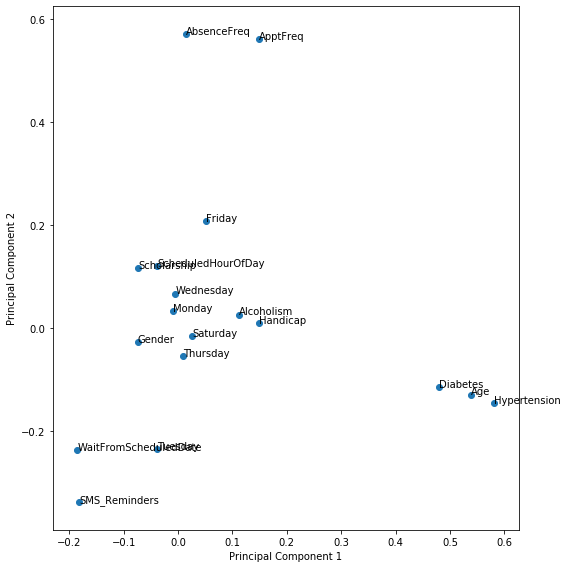

In [124]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

Interesting... we can see which variables are clustered near each other and might be experiencing some degreee of a  collinearity issue.

Similiar variables:


[Absencefreq, ApptFreq]
[Age, Diabetes, Hypertension]
[Tuesday, WaitFromScheduledDate, SMSReminders]
[Thursday,Saturday, Monday, Geder, Handicap, Alcoholism, WEdnesday, ScheduledHourofDay, Scholarship, Friday]

Can I predict who's on scholarship?

In [125]:
pca.explained_variance_ratio_

array([1.08516358e-01, 8.45567460e-02, 8.04959464e-02, 7.28445266e-02,
       7.00703520e-02, 6.55260154e-02, 6.25085970e-02, 5.95323522e-02,
       5.75576531e-02, 5.54493379e-02, 5.42887144e-02, 5.36846404e-02,
       4.73528885e-02, 3.80528069e-02, 3.71663923e-02, 2.84696134e-02,
       2.39270591e-02, 1.10354001e-30])

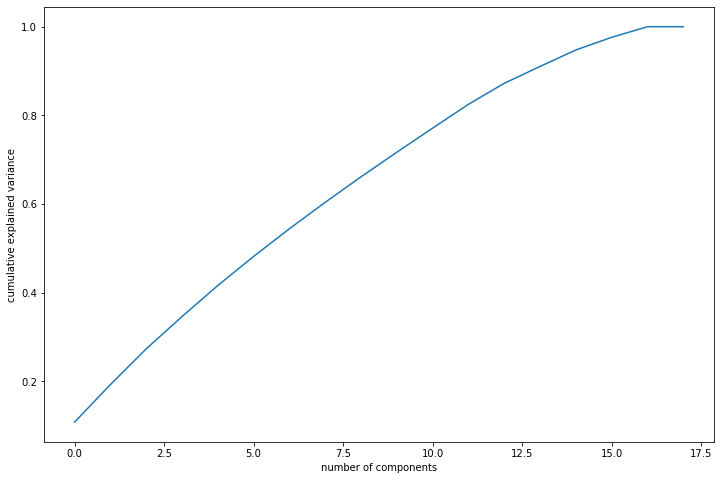

In [126]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Select somewhere between 15-17 features to explain the variance... After that, the the graph of explained variance approaches an asymptote

In [127]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=15)

In [128]:
df_train_pca = pca_final.fit_transform(X_tr)
df_train_pca.shape

(65888, 15)

In [129]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

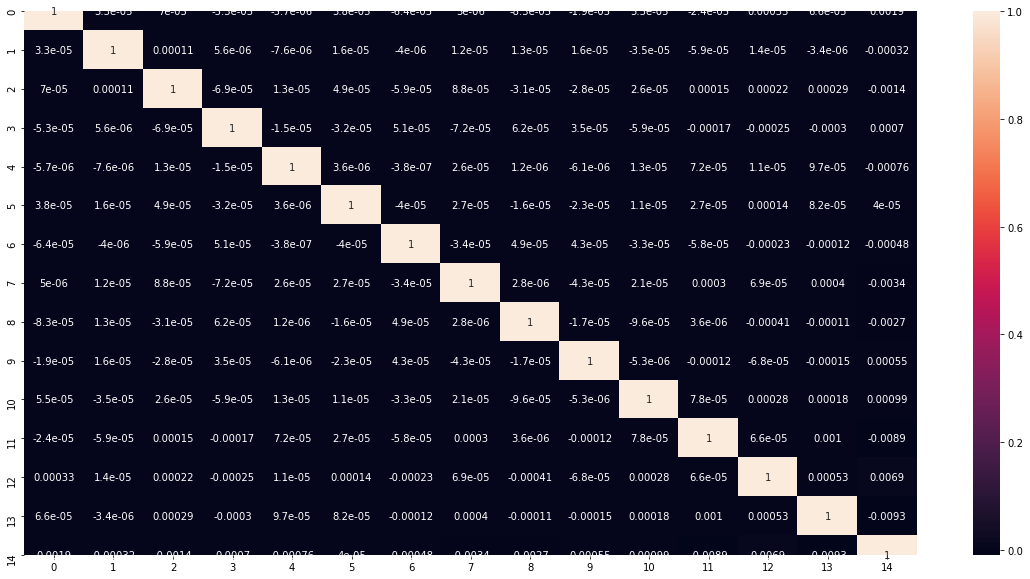

In [130]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

In [131]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.006862252773496958 , min corr:  -0.009347021467324015


Confirmed that we've removed multicolinearity issues

In [132]:
X_test.head()

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Reminders,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday,WaitFromScheduledDate,ScheduledHourOfDay,ApptFreq,AbsenceFreq
0,-0.728259,2.062223,-0.337846,-0.501125,-0.279636,-0.166908,-0.127607,-1.296920,-0.470161,-0.518885,-0.019903,-0.421087,1.836686,-0.583945,-0.990265,1.347499,-0.079322,-0.897418
1,1.475850,-0.852618,-0.337846,-0.501125,-0.279636,-0.166908,-0.127607,-1.296920,-0.470161,-0.518885,-0.019903,-0.421087,1.836686,-0.583945,0.908198,0.427193,1.105453,1.220578
2,-0.728259,-1.029275,-0.337846,-0.501125,-0.279636,-0.166908,-0.127607,-1.296920,-0.470161,-0.518885,-0.019903,-0.421087,-0.578974,1.815233,-0.719056,0.120424,-0.079322,0.161580
3,-0.728259,1.223103,-0.337846,-0.501125,-0.279636,-0.166908,-0.127607,-1.296920,-0.470161,2.046656,-0.019903,-0.421087,-0.578974,-0.583945,-0.719056,2.267805,1.105453,-0.897418
4,1.475850,0.781460,-0.337846,-0.501125,-0.279636,-0.166908,-0.127607,0.815151,-0.470161,-0.518885,-0.019903,-0.421087,1.836686,-0.583945,-0.719056,1.654267,-0.671709,0.161580


In [133]:
#Applying selected components to the test data - 40 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(11442, 15)

# Logistic Regression Post PCA

In [134]:
#Training the model on the train data


learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [135]:
#Making prediction on the train data
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_tr, pred_probs_train))

'0.95'

In [136]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.95'

Predictions on the training data

In [137]:
predictions_train = model_pca.predict(df_train_pca)

In [138]:
print(confusion_matrix(y_tr,predictions_train))

[[31105  1839]
 [ 3617 29327]]


In [139]:
print(classification_report(y_tr,predictions_train))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     32944
           1       0.94      0.89      0.91     32944

    accuracy                           0.92     65888
   macro avg       0.92      0.92      0.92     65888
weighted avg       0.92      0.92      0.92     65888



In [140]:
predictions_test = model_pca.predict(df_test_pca)

In [141]:
print(confusion_matrix(y_test,predictions_test))

[[2977  240]
 [ 882 7343]]


In [142]:
print(classification_report(y_test,predictions_test))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      3217
           1       0.97      0.89      0.93      8225

    accuracy                           0.90     11442
   macro avg       0.87      0.91      0.89     11442
weighted avg       0.91      0.90      0.90     11442



In [143]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the imbalanced training dataset
pca_y_train_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), pred_probs_train.tolist())),
              columns=['Attendance','Attendance_prob'])

In [144]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the testing dataset
pca_y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), pred_probs_test.tolist())),
              columns=['Attendance','Attendance_prob'])

In [145]:
fpr, tpr, thresholds = metrics.roc_curve(pca_y_train_pred_final.Attendance, pca_y_train_pred_final.Attendance_prob, drop_intermediate = False )

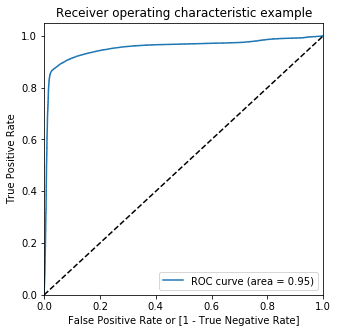

In [146]:
draw_roc(pca_y_train_pred_final.Attendance, pca_y_train_pred_final.Attendance_prob)

In [147]:
fpr, tpr, thresholds = metrics.roc_curve( pca_y_test_pred_final.Attendance, pca_y_test_pred_final.Attendance_prob, drop_intermediate = False )

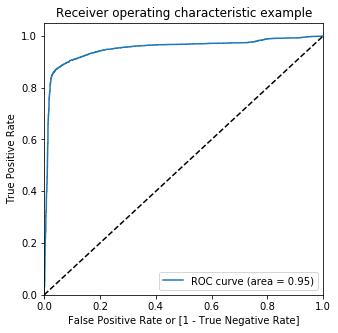

In [148]:
draw_roc(pca_y_test_pred_final.Attendance, pca_y_test_pred_final.Attendance_prob)

Text(0.5, 1.0, 'Attendance by Age')

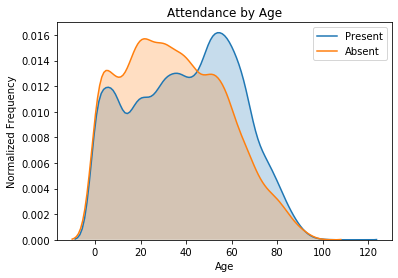

In [161]:
# Attendance distribution by Age
sns.kdeplot(df.loc[df['Attendance'] == 1, 'Age'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'Age'], label = 'Absent', shade = True)
plt.xlabel('Age')
plt.ylabel('Normalized Frequency')
plt.title('Attendance by Age')


Text(0.5, 1.0, 'Attendance by Waiting')

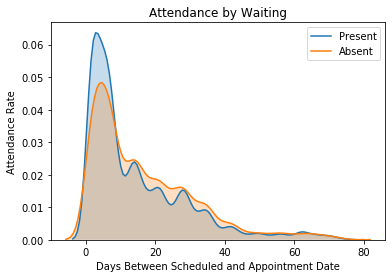

In [164]:
# Grade distribution by address
sns.kdeplot(df.loc[df['Attendance'] == 1, 'WaitFromScheduledDate'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'WaitFromScheduledDate'], label = 'Absent', shade = True)
plt.xlabel('Days Between Scheduled and Appointment Date')
plt.ylabel('Attendance Rate')
plt.title('Attendance by Waiting')



[-1, 30, 0, 0.1]

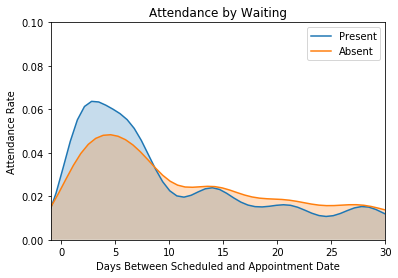

In [166]:
# Grade distribution by address
sns.kdeplot(df.loc[df['Attendance'] == 1, 'WaitFromScheduledDate'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'WaitFromScheduledDate'], label = 'Absent', shade = True)
plt.xlabel('Days Between Scheduled and Appointment Date')
plt.ylabel('Attendance Rate')
plt.title('Attendance by Waiting')

plt.axis([-1,30,0,0.1])

From this figure we can make a policy recommendation - as much as possible - try to schedule appointments less than 10 days out. Further out, we run a higher risk of no-shows.

In [151]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighborhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Attendance',
       'AppointmentDayOfWeek', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday', 'ScheduledDayOfWeek', 'WaitFromScheduledDate',
       'ScheduledHourOfDay', 'ApptFreq', 'AbsenceFreq'],
      dtype='object')

In [153]:


# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse



In [154]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [156]:
# Load data

X_trainGB = X_train.to_numpy()

In [157]:
X_testGB = X_test.to_numpy()


In [158]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_trainGB, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0954


Text(0, 0.5, 'Deviance')

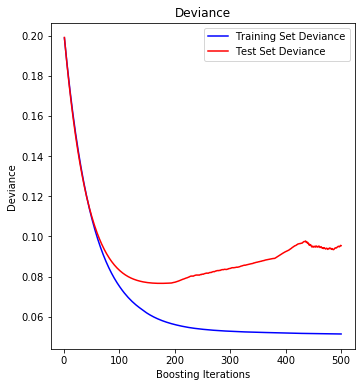

In [159]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_testGB)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

AttributeError: 'DataFrame' object has no attribute 'get_feature_names'

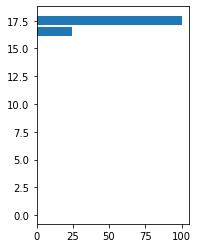

In [160]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.get_feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [168]:
selection=[]
for i in y_pred:
    if i >= 0.4:
        selection.append(1)
    else:
        selection.append(0)

selectionfortesting = np.asarray(selection)

In [169]:
print(confusion_matrix(y_test, selectionfortesting))
print(classification_report(y_test, selectionfortesting ))

[[2416  801]
 [ 491 7734]]
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      3217
           1       0.91      0.94      0.92      8225

    accuracy                           0.89     11442
   macro avg       0.87      0.85      0.86     11442
weighted avg       0.89      0.89      0.89     11442

